In [1]:
import Pkg
Pkg.activate(joinpath(@__DIR__, ".."))
Pkg.instantiate()

In [2]:
using Aiyagari
using Plots 
using PrettyTables
using Roots
using UnPack
using ProgressMeter

In [3]:
ProgressMeter.ijulia_behavior(:clear);
# pgfplotsx();
gr()
default(label = "", lw = 2, dpi = 300, left_margin = 0Plots.mm, format=:png);

# Mark-up Economy

In [4]:
e_μ = let 
    #Household:
    ar1 = 0.9695
    sigmaP = sqrt(0.0384)/(1.2)
    sigmaIID = sqrt(0.0522)/(1.2)
    P, z_vals = calibration(5, 2 , ar1, sigmaP, sigmaIID)

    ies = 1.0
    crra = 5.5
    β = 0.993
    
    hh = Household(u = EZ(ies = ies, ra = crra), grid_points = 5_000,
        v = GHH(θ = 1.0, ν = 0.2), P = P, z_grid = z_vals, β = β, a_max = 10.0)

    #Technology
    δ = 0.1
    μ = 1.4
    α = .3
    #ρ = 0.7
    A_μ = 0.2
    # t_μ = MarkupTechnology(f = CES(α = α, ρ = 0.7), δ = δ, μ = μ, A = A_μ)
    t_μ = MarkupTechnology(f = CobbDouglas(α = α), δ = δ, μ = μ, A = A_μ)

    Economy(h = hh, t = t_μ)
end

Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336605..3.621762275547772], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, g=0.0, δ=0.1, μ=1.4, m=0.0, X=0.0

In [5]:
# Solve laissez-faire economy
r_range = (-0.0171, -0.016)
@time laissez_faire_μ = solve_laissez_faire(e_μ; 
    r_range = r_range, 
    tol =  (value_function = 1e-10, distribution = 1e-13)
)

Progress:  15 	 Time: 0:00:45
  r:       -0.01695171007102314
  excess:  1.1102230246251565e-16

 58.435692 seconds (30.81 M allocations: 1.733 GiB, 1.04% gc time, 24.84% compilation time)


r=-0.01695171007102314, b=0.0, k=0.5596544237494964, transfer=0.0,  y=0.21689893327005239, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336605..3.621762275547772], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, g=0.0, δ=0.1, μ=1.4, m=0.0, X=0.0

# Dynamic Efficient -- No change in K

## new steady state interest rate and eq

In [36]:
final_eq_μ = let 
    r = -0.013930022583173161  # using a good guess
    b_target = laissez_faire_μ.y * 0.60
    k_target = laissez_faire_μ.k
    @time solve_new_stationary_equilibrium_given_k_b(
        laissez_faire_μ,
        k_target, 
        b_target; 
        r_range = (r - 1e-8, r + 1e-8),
        tol = (value_function = 1e-10, distribution = 1e-13)
    )
end

Progress:  38 	 Time: 0:00:19
  tr:      0.00012174345346706653
  excess:  -1.2265211049022895e-6
  r:       -0.01393002258317316

 19.318740 seconds (939.64 k allocations: 63.696 MiB)


r=-0.013930022583173161, b=0.13013935996203144, k=0.5596544237494964, transfer=0.00012174345346706826,  y=0.21689893327005239, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336605..3.621762275547772], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, g=0.0, δ=0.1, μ=1.4, m=0.0, X=0.0

# trace out household savings

In [7]:
eq_μ = let
    y_0=laissez_faire_μ.y
    b_range = range(-0.5 * y_0, 3 * y_0, length = 20)
    k_target = laissez_faire_μ.k
    eqs = []
    for b in b_range
        push!(eqs, 
            solve_new_stationary_equilibrium_given_k_b(
                laissez_faire_μ,
                k_target, 
                b; 
                r_range = (-0.05, 0.0),
                tol = (value_function = 1e-6, distribution = 1e-6)
            )
        )
    end
    eqs
end 

Progress:  66 	 Time: 0:01:06
  tr:      -0.0005248876708391706
  excess:  -0.0035421740399721457
  r:       -0.007404637336730955┌ Warning: amax is binding
└ @ Aiyagari C:\Users\amado\Documents\GitHub\aiyagari\src\household.jl:518
┌ Warning: Equilibrium is not valid
└ @ Aiyagari C:\Users\amado\Documents\GitHub\aiyagari\src\equilibrium.jl:233


20-element Vector{Any}:
 r=-0.0204074740409851, b=-0.10844946663502619, k=0.5596544237494964, transfer=-0.00027914608188963144,  y=0.21689893327005239, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336605..3.621762275547772], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, g=0.0, δ=0.1, μ=1.4, m=0.0, X=0.0
 r=-0.019011068344116207, b=-0.06849439998001654, k=0.5596544237494964, transfer=-0.00014962275158765526,  y=0.21689893327005239, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336605..3.621762275547772], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, g=0.0, δ=0.1, μ=1.4, m=0.0, X=0.0
 r=-0.01779680252075195, b=-0.028539333325006893, k=0.5596544237494964, transfer=-3.4949151291024244e-5,  y=0.21689893327005239, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336605..3.621762275547772], P=[..], pts=5000, a_max=10.0, a_mi

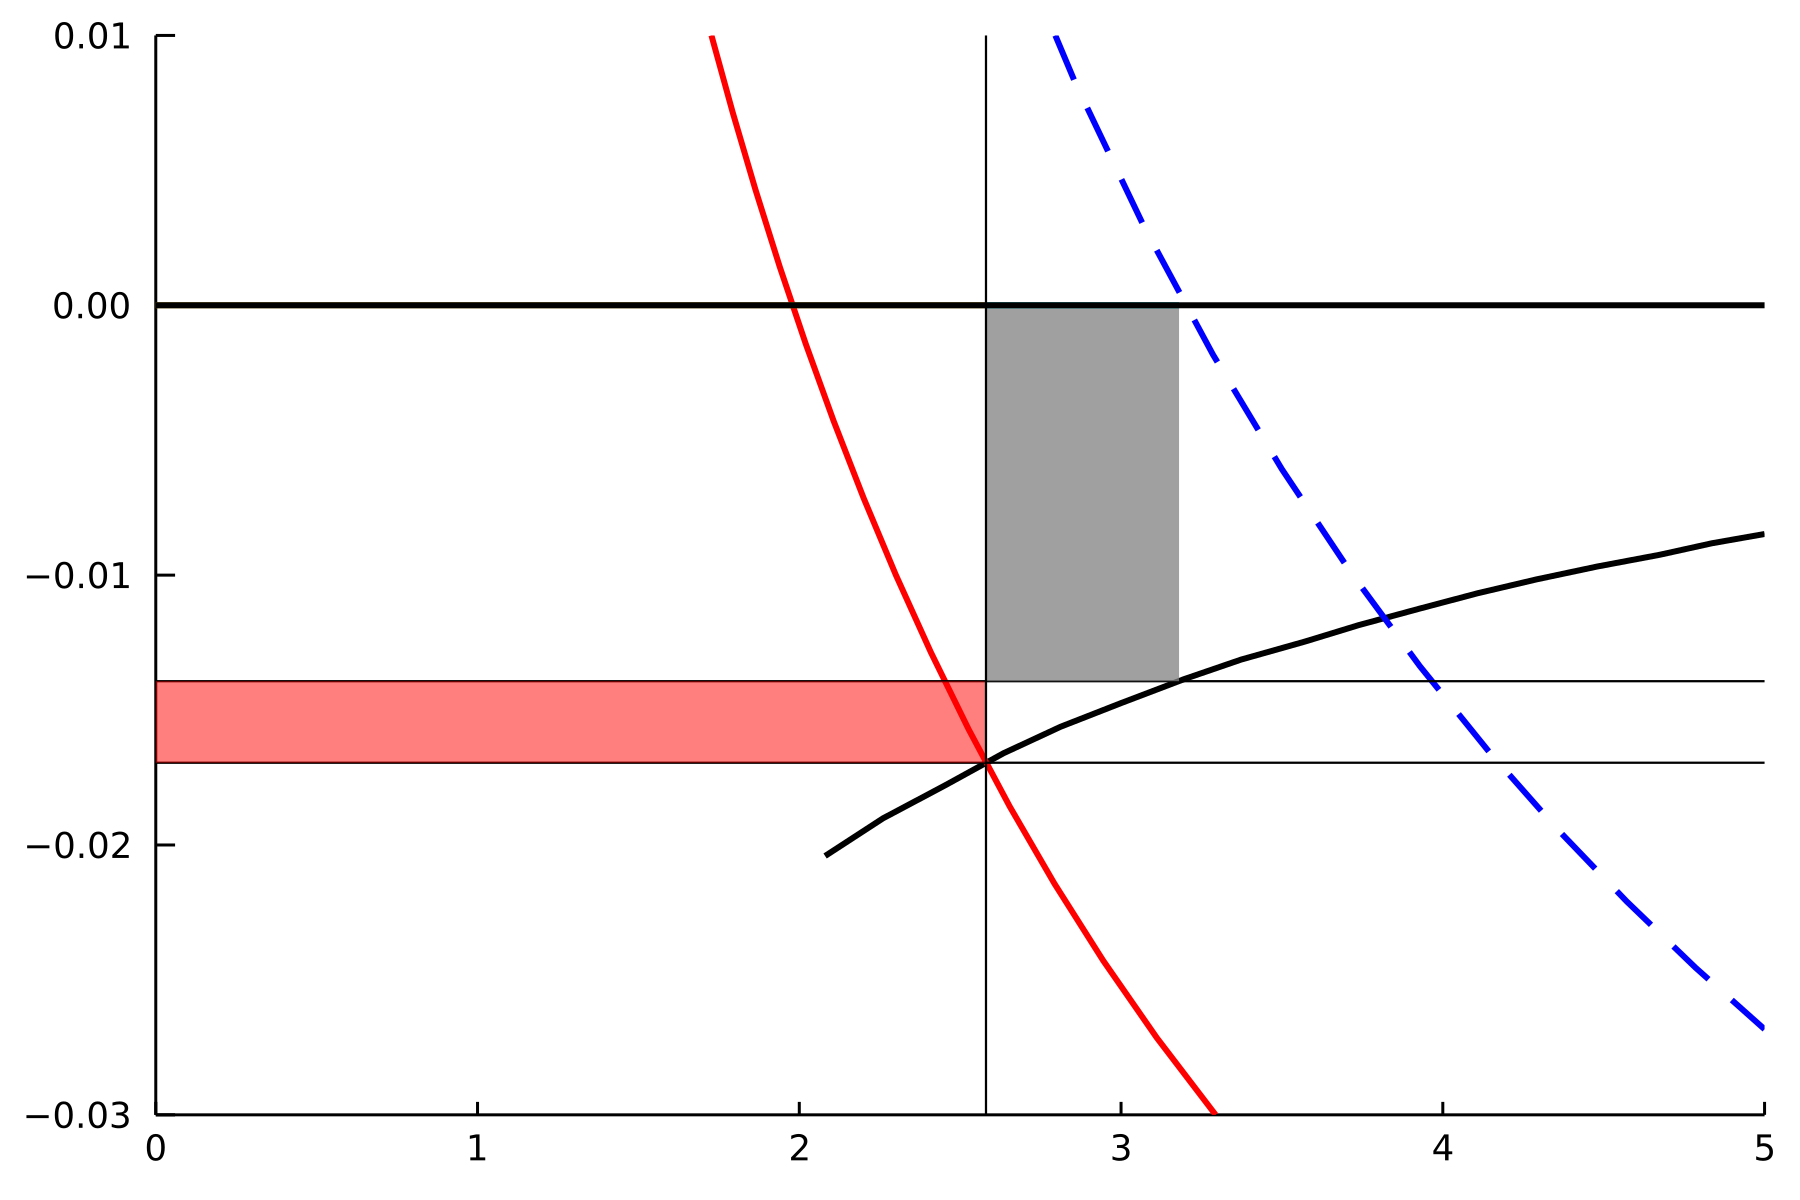

In [8]:
let 
    get_ky = (r, t, n) -> begin 
        k = k_from_mpk(t, 
                    mpk = mpk_from_after_tax_rK(t, r + t.δ),
                    n = n)
        y = output(t, k = k, n = n)
        return k / y
    end

    get_k = (r, t, n) -> begin 
        k = k_from_mpk(t, 
                    mpk = mpk_from_after_tax_rK(t, r + t.δ),
                    n = n)
        return k
    end


    t = get_t(laissez_faire_μ)
    n0 = laissez_faire_μ.n
    y0 = laissez_faire_μ.y
    y1 = final_eq_μ.y
    ky_0 = laissez_faire_μ.k / y0 
    ky_1 = final_eq_μ.k / y1 
    sy_1 = final_eq_μ.s / y1 
    r_1 = final_eq_μ.r
    r_0= laissez_faire_μ.r
    
    # plot([(eq.s / eq.y, eq.r) for eq in eq_μ ], color = :black)
    plot([(eq.s / y0, eq.r) for eq in eq_μ ], color = :black)    
   #  plot!([(get_ky(r, t, n0), r) for r in range(-0.03, 0.01, length = 15)], color = :red)
     plot!([(get_k(r, t, n0)/y0, r) for r in range(-0.03, 0.01, length = 15)], color = :red)    
    # plot!([ (k / output(t, n = n0, k = k), mpk_from_factors(t, k = k, n = n0) - t.δ) for k in range(2 * y0, 5 * y0, length = 15)], 
     #   color = :blue, style = :dash)
     plot!([ (k / y0, mpk_from_factors(t, k = k, n = n0) - t.δ) for k in range(2 * y0, 5 * y0, length = 15)], 
        color = :blue, style = :dash)

    ylims!(-0.03, 0.01)
    xlims!(0.0, 5)
    hline!([laissez_faire_μ.r, final_eq_μ.r], color = :black, lw = 0.75)
    
    plot!([0,ky_0],             # xlims for shade
         [0,0],                   # dummy y coordinates
         fillrange = (r_0,r_1), # apply ylims
         fillalpha = 0.5,         # set transparency
         fillcolor=:red,         # set shade color
         label = "Cost: Δr*K/Y")   

    plot!([ky_0,final_eq_μ.s/y0],             # xlims for shade
             [0,0],                   # dummy y coordinates
             fillrange = (r_1,0.0), # apply ylims
             fillalpha = 0.75,         # set transparency
             fillcolor=:gray,         # set shade color
             label = "Revenue: r*dS", legend=false, grid=false)  

    
    hline!([0], color = :black, lw = 2)
    vline!([laissez_faire_μ.k / laissez_faire_μ.y], color = :black, lw = 0.75)
end

In [9]:
savefig(joinpath(@__DIR__, "..", "output", "figures", "CostBenefit_Efficient.pdf"))


# Crowding in

In [10]:
kGR=golden_rule_k(e_μ.t,laissez_faire_μ.n)

0.694116570283737

In [11]:
eq_crowdin = let
    y_0 = laissez_faire_μ.y
    eq_crowdin=[]
    b_range = range(-0.5 * y_0,0.0, length=5)
    for b in b_range
        push!(eq_crowdin, 
            solve_new_stationary_equilibrium_given_k_b(
                laissez_faire_μ,
                laissez_faire_μ.k, 
                b; 
                r_range = (-0.05, 0.0),
                tol = (value_function = 1e-6, distribution = 1e-6)
            )
        )    
    end
    
    k_range = range(laissez_faire_μ.k,kGR, length = 10)
    for k in k_range
        push!(eq_crowdin, 
            solve_new_stationary_equilibrium_given_k_b(
                laissez_faire_μ ,
                k, 
                0.0; 
                r_range = (-0.05, 0.0),
                tol = (value_function = 1e-6, distribution = 1e-6)
            )
        )
    end
    
    b_range = range(0.0, 2.5 * y_0, length = 15)
    for b in b_range
        push!(eq_crowdin, 
            solve_new_stationary_equilibrium_given_k_b(
                laissez_faire_μ ,
                kGR, 
                b; 
                r_range = (-0.05, 0.0),
                tol = (value_function = 1e-6, distribution = 1e-6)
            )
        )
    end 
    
    
    eq_crowdin
end


Progress:  67 	 Time: 0:00:57
  tr:      9.425918778897639e-5
  excess:  0.0067973033960331275
  r:       -0.006918931007385251┌ Warning: amax is binding
└ @ Aiyagari C:\Users\amado\Documents\GitHub\aiyagari\src\household.jl:518
┌ Warning: Equilibrium is not valid
└ @ Aiyagari C:\Users\amado\Documents\GitHub\aiyagari\src\equilibrium.jl:233


30-element Vector{Any}:
 r=-0.0204074740409851, b=-0.10844946663502619, k=0.5596544237494964, transfer=-0.00027914608188963144,  y=0.21689893327005239, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336605..3.621762275547772], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, g=0.0, δ=0.1, μ=1.4, m=0.0, X=0.0
 r=-0.019436061382293694, b=-0.08133709997626964, k=0.5596544237494964, transfer=-0.0001904946662960958,  y=0.21689893327005239, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336605..3.621762275547772], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, g=0.0, δ=0.1, μ=1.4, m=0.0, X=0.0
 r=-0.018525362014770504, b=-0.054224733317513096, k=0.5596544237494964, transfer=-0.0001238315431010984,  y=0.21689893327005239, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336605..3.621762275547772], P=[..], pts=5000, a_max=10.0, a_mi

In [12]:
@time crowdin_final = solve_new_stationary_equilibrium_given_k_b(
    laissez_faire_μ,
    kGR, 
    0.6*laissez_faire_μ.y; 
    r_range = (laissez_faire_μ.r, -0.010),
    tol = (value_function = 1e-10, distribution = 1e-13)
)

Progress:  57 	 Time: 0:02:43
  tr:      0.0008022840679689173
  excess:  1.9431245115164586e-6
  r:       -0.011237215394339493

163.893125 seconds (7.00 M allocations: 531.767 MiB, 0.11% gc time)


r=-0.011237215394339495, b=0.13013935996203144, k=0.694116570283737, transfer=0.000802284067968919,  y=0.231372190094579, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336605..3.621762275547772], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, g=0.0, δ=0.1, μ=1.4, m=0.0, X=0.0

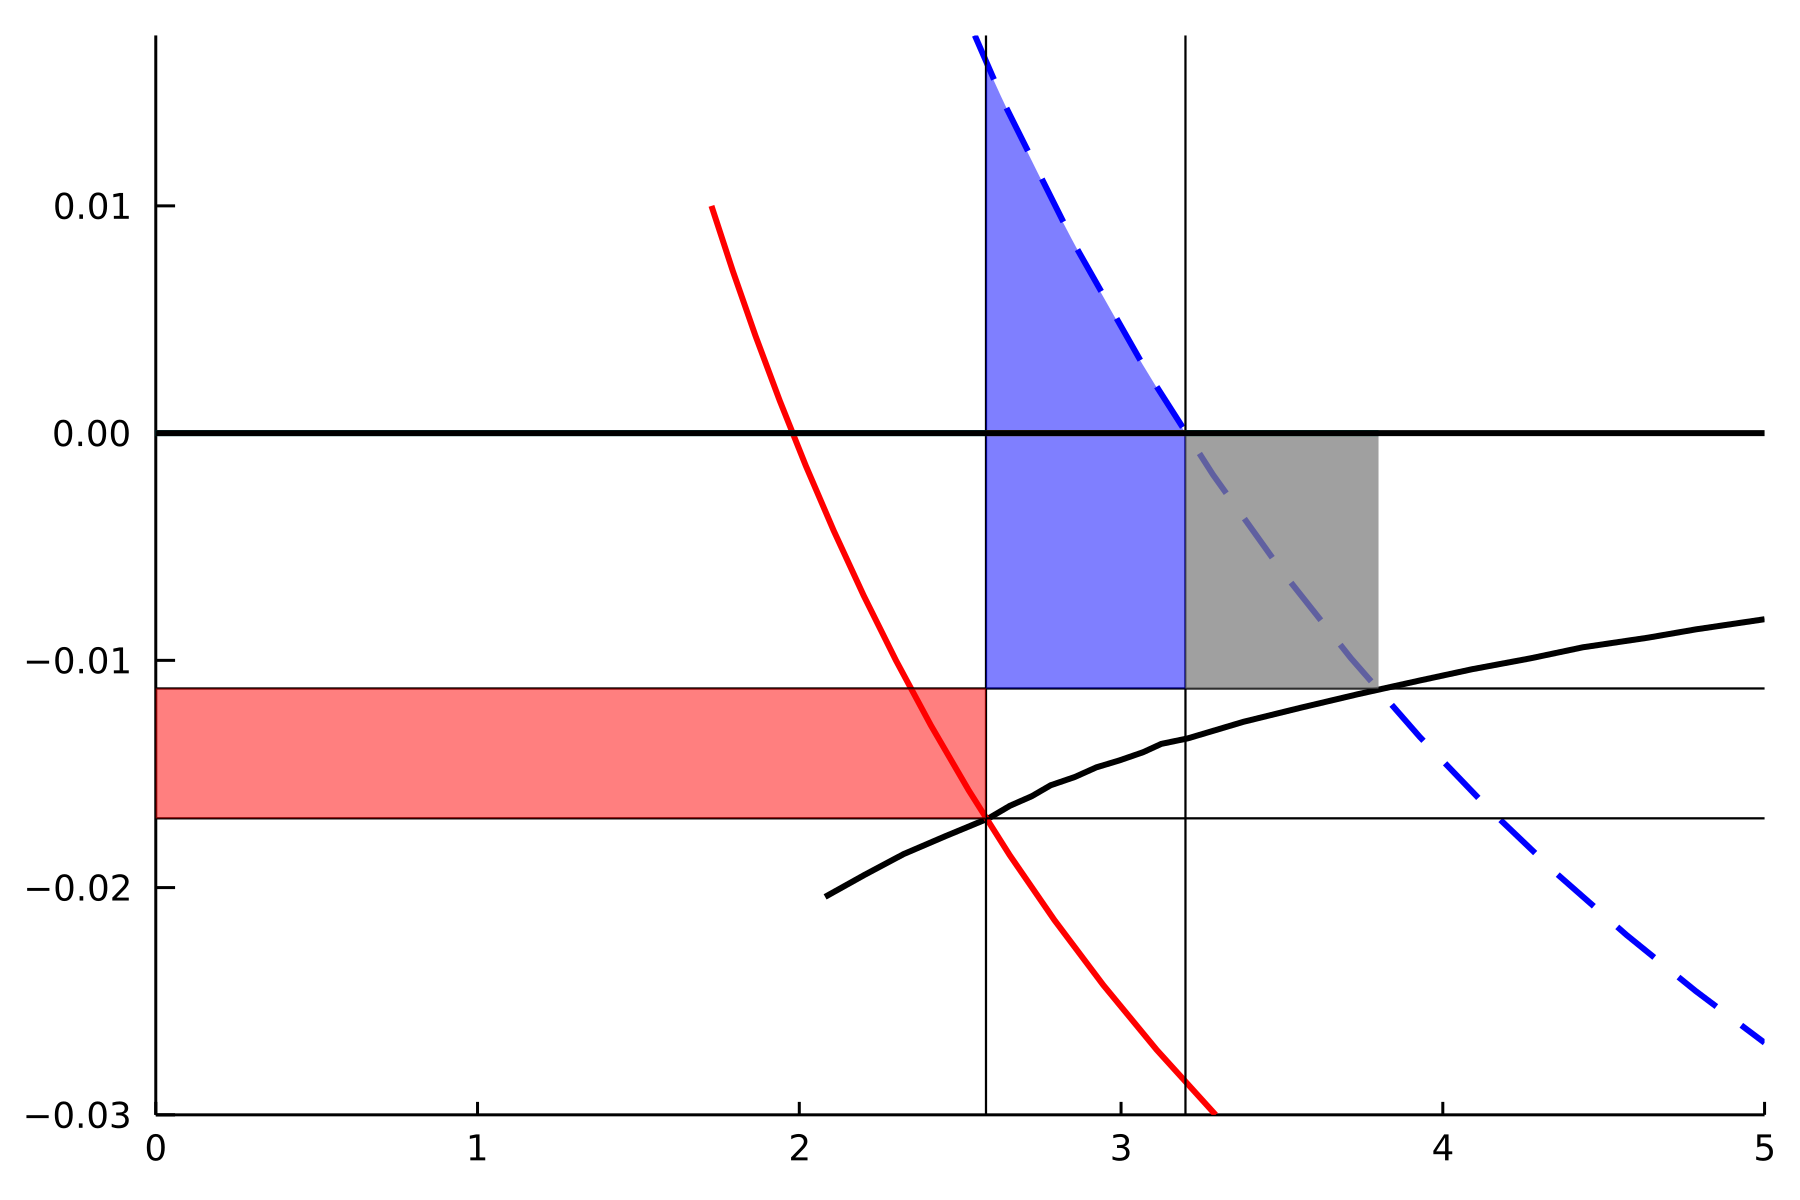

In [13]:
let 
    get_ky = (r, t, n) -> begin 
        k = k_from_mpk(t, 
                    mpk = mpk_from_after_tax_rK(t, r + t.δ),
                    n = n)
        y = output(t, k = k, n = n)
        return k / y
    end
    
       get_k = (r, t, n) -> begin 
        k = k_from_mpk(t, 
                    mpk = mpk_from_after_tax_rK(t, r + t.δ),
                    n = n)
        return k
    end


    r_0=laissez_faire_μ.r
    t = get_t(laissez_faire_μ)
    n0 = laissez_faire_μ.n
    y0 = laissez_faire_μ.y
    y1 = crowdin_final.y
    ky_0 = laissez_faire_μ.k / y0 
    ky_1 = crowdin_final.k / y1 
    sy_1 = crowdin_final.s / y1 
    r_1 = crowdin_final.r
    
    plot([(eq.s / y0, eq.r) for eq in eq_crowdin], color = :black)
   # plot!([(get_k(r, t, n0), r) for r in range(-0.03, 0.01, length = 15)], color = :red)
    plot!([(get_k(r, t, n0)/y0, r) for r in range(-0.03, 0.01, length = 15)], color = :red)
    # plot!([ (k / output(t, n = n0, k = k), mpk_from_factors(t, k = k, n = n0) - t.δ) for k in range(2 * y0, 5 * y0, length = 15)], 
    #    color = :blue, style = :dash)
    plot!([ (k / y0, mpk_from_factors(t, k = k, n = n0) - t.δ) for k in range(2 * y0, 5 * y0, length = 15)], 
        color = :blue, style = :dash)
    ylims!(-0.03, 0.0175)
    xlims!(0.0, 5)
    hline!([laissez_faire_μ.r, crowdin_final.r], color = :black, lw = 0.75)
    vline!([laissez_faire_μ.k / laissez_faire_μ.y, kGR/laissez_faire_μ.y], color = :black, lw = 0.75)
    
        plot!([0,ky_0],             # xlims for shade
         [0,0],                   # dummy y coordinates
         fillrange = (r_0,r_1), # apply ylims
         fillalpha = 0.5,         # set transparency
         fillcolor=:red,         # set shade color
         label = "Cost: Δr*K/Y")   

plot!([  (k / y0, mpk_from_factors(t, k = k, n = n0) - t.δ) for k in range(laissez_faire_μ.k,kGR, length = 15)],
fill = (0, 0.5, :blue),lw=0.0)
    

       plot!([ky_0,crowdin_final.k /y0],             # xlims for shade
         [0,0],                   # dummy y coordinates
         fillrange = (r_1,0.0), # apply ylims
         fillalpha = 0.5,         # set transparency
         fillcolor=:blue,         # set shade color
         label = "Revenue I: (MPK-δ)* ΔK/Y")   


    plot!([crowdin_final.k /y0,crowdin_final.s/y0],             # xlims for shade
             [0,0],                   # dummy y coordinates
             fillrange = (r_1,0.0), # apply ylims
             fillalpha = 0.75,         # set transparency
             fillcolor=:gray,         # set shade color
             label = "Revenue II: r*ΔS/Y")  

    
    hline!([0], color = :black, lw = 2,legend=false, grid=false)



end

In [14]:
savefig(joinpath(@__DIR__, "..", "output", "figures", "CostBenefit_Crowdin.pdf"))

# Competititive Case

In [15]:
e = let 
    P, z_vals = let
        ar1 = 0.9695
        sigmaP = sqrt(0.0384)/(1.2)
        sigmaIID = sqrt(0.0522)/(1.2)
         calibration(5, 2 , ar1, sigmaP, sigmaIID)
    end
    # Technology
    t = let 
        θ = 0.3
        ls = 1 - θ
        δ = 0.1
        #α1, A1 = get_tech_params(1, θ = θ)
        g = 0.0
        A1=1.0
        α1=0.3
        Technology(f = CobbDouglas(α = α1), δ = δ, g = g)
    end
    # Households
    h = let 
        g = 0.0
        ies = 1.0
        β = 0.99 #* (1 + g)^(1 - 1/ies)
        Household(
            u = EZ(ies = 1.0, ra = 5.5),
            v = GHH(θ = 1.0, ν = 0.2), 
            P = P, z_grid = z_vals, β = β, a_max = 100.0)
    end
    Economy(h = h, t = t)
end 


Economy: EZ(ies = 1.0, ra = 5.5), β=0.99, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336605..3.621762275547772], P=[..], pts=10000, a_max=100.0, a_min=0.0, CobbDouglas(α=0.3), A=1.0, g=0.0, δ=0.1

In [16]:
# Solve laissez-faire economy
r_range = (-0.0172, -0.0171) # narrowing the range
@time laissez_faire = solve_laissez_faire(e; 
    r_range = r_range, 
    tol =  (value_function = 1e-10, distribution = 1e-13)
) 


Progress:  45 	 Time: 0:01:29
  r:       -0.01717815974662335
  excess:  -6.3700051473603025e-6

 90.036186 seconds (2.99 M allocations: 200.793 MiB, 0.04% gc time, 0.16% compilation time)


r=-0.017178159746623352, b=0.0, k=6.902156744423144, transfer=0.0,  y=1.9054977443012666, Economy: EZ(ies = 1.0, ra = 5.5), β=0.99, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336605..3.621762275547772], P=[..], pts=10000, a_max=100.0, a_min=0.0, CobbDouglas(α=0.3), A=1.0, g=0.0, δ=0.1

In [17]:
@time final_eq = let
    b_target = laissez_faire.y*0.6
    r_range_2 = (-0.0152, -0.0148)  # narrowing the range
    solve_new_stationary_equilibrium_given_k_b(
    laissez_faire;
    k_b_fun = (r) -> begin
        # returns k consistent with r and no capital taxes
        t = get_t(laissez_faire)
        b = b_target
        rK = rK_from_r(;t, r)
        mpk = mpk_from_after_tax_rK(t, rK)
        k = k_from_mpk(t; mpk, laissez_faire.n)
        return (k, b)
    end,
    r_range = r_range_2,
    tol = (value_function = 1e-7, distribution = 1e-8)
    )
end


Progress:  19 	 Time: 0:00:46
  tr:      0.0025538567185157957
  excess:  3.428328287924387e-8
  r:       -0.015020761108398431

 47.877088 seconds (3.64 M allocations: 230.278 MiB, 0.13% gc time, 1.79% compilation time)


r=-0.015020761108398431, b=1.14329864658076, k=6.653200134983302, transfer=0.0025538567185157957,  y=1.8846129455479395, Economy: EZ(ies = 1.0, ra = 5.5), β=0.99, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336605..3.621762275547772], P=[..], pts=10000, a_max=100.0, a_min=0.0, CobbDouglas(α=0.3), A=1.0, g=0.0, δ=0.1

In [18]:
eq_nomarkup = let
    b_range = range(-1.0 * laissez_faire.y, 4.5 * laissez_faire.y, length = 15)
    eq_nomarkup = []
    for b in b_range
        push!(eq_nomarkup, 
            solve_new_stationary_equilibrium_given_k_b(
                laissez_faire;
                k_b_fun = (r) -> begin
                    # returns k consistent with r and no capital taxes
                    t = get_t(laissez_faire)
                    rK = rK_from_r(;t, r)
                    mpk = mpk_from_after_tax_rK(t, rK)
                    k = k_from_mpk(t; mpk, laissez_faire.n)
                    return (k, b)
                end,
                r_range = [-.03,0.0],
                tol = (value_function = 1e-7, distribution = 1e-8)
            )
        )
    end
    eq_nomarkup
end
    

Progress:  66 	 Time: 0:03:14
  tr:      -0.007085453418911758
  excess:  -4.381745704051809e-6
  r:       -0.006828741729259488┌ Warning: amax is binding
└ @ Aiyagari C:\Users\amado\Documents\GitHub\aiyagari\src\household.jl:518
┌ Warning: Equilibrium is not valid
└ @ Aiyagari C:\Users\amado\Documents\GitHub\aiyagari\src\equilibrium.jl:233


15-element Vector{Any}:
 r=-0.021659628525376305, b=-1.9054977443012666, k=7.4730524645174246, transfer=-0.009090146695884815,  y=1.951472353732157, Economy: EZ(ies = 1.0, ra = 5.5), β=0.99, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336605..3.621762275547772], P=[..], pts=10000, a_max=100.0, a_min=0.0, CobbDouglas(α=0.3), A=1.0, g=0.0, δ=0.1
 r=-0.019753887653350823, b=-1.1569093447543406, k=7.220812484331162, transfer=-0.004670241911582967,  y=1.9314737661724182, Economy: EZ(ies = 1.0, ra = 5.5), β=0.99, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336605..3.621762275547772], P=[..], pts=10000, a_max=100.0, a_min=0.0, CobbDouglas(α=0.3), A=1.0, g=0.0, δ=0.1
 r=-0.018038934171199787, b=-0.4083209452074143, k=7.0059437219693566, transfer=-0.001379994954072039,  y=1.9140487152973333, Economy: EZ(ies = 1.0, ra = 5.5), β=0.99, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336605..3.621762275547772], P=[..], pts=10000, a_max=100.0, a_min=0.0, CobbDouglas(α=0.3), A=1.0, g=0.0, δ=0.1
 r=

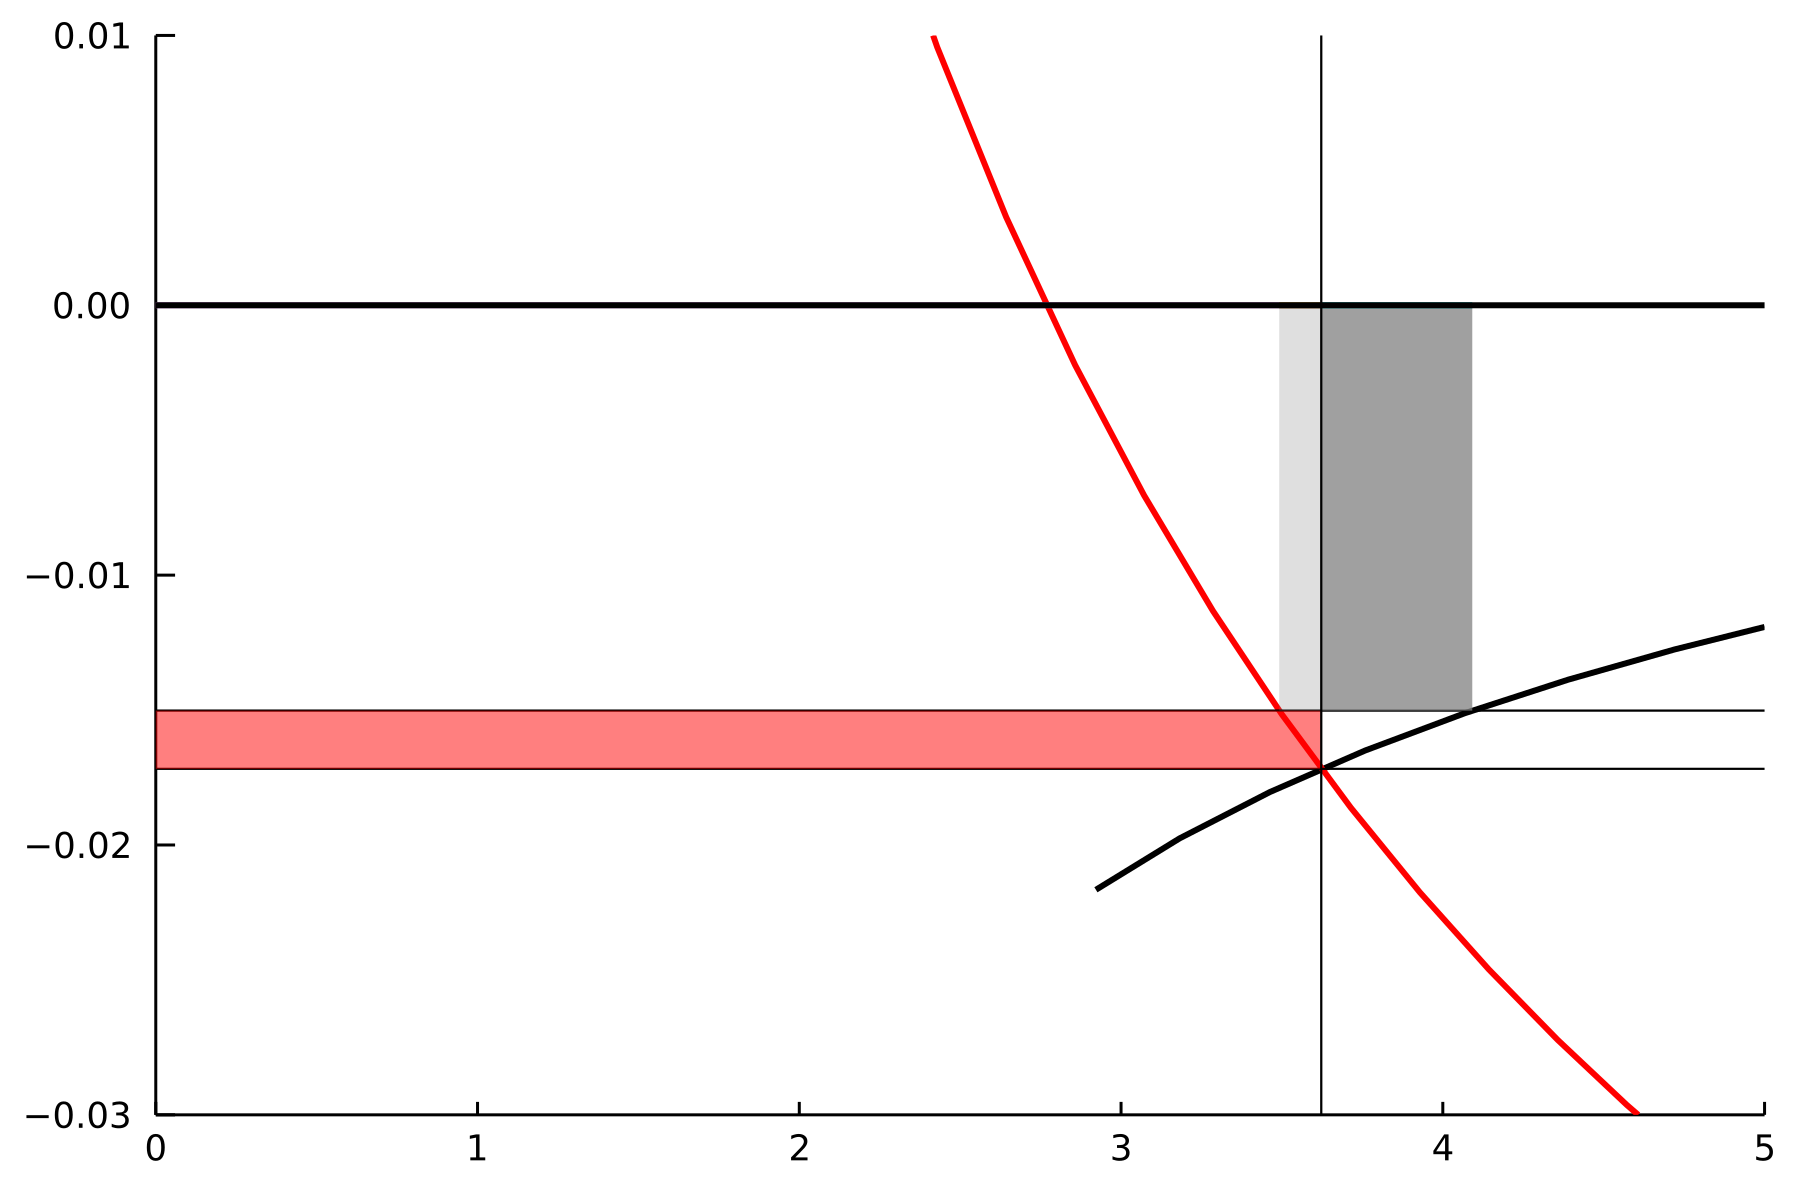

In [19]:
let 
    get_ky = (r, t, n) -> begin 
        k = k_from_mpk(t, 
                    mpk = mpk_from_after_tax_rK(t, r + t.δ),
                    n = n)
        y = output(t, k = k, n = n)
        return k / y
    end
    
    t = get_t(laissez_faire)
    n0 = laissez_faire.n
    y0 = laissez_faire.y
    y1 = final_eq.y
    ky_0 = laissez_faire.k / y0 
    ky_1 = final_eq.k / y1 
    sy_1 = final_eq.s / y1 
    r_1 = final_eq.r
    
 plot([(eq.s / y0, eq.r) for eq in eq_nomarkup], color = :black)
 plot!([ (k / y0, mpk_from_factors(t, k = k, n = n0) - t.δ) for k in range(2 * y0, 5 * y0, length = 15)], color = :red)


    ylims!(-0.03, 0.01)
    xlims!(0.0, 5)
    hline!([laissez_faire.r, final_eq.r], color = :black, lw = 0.75)
    
    plot!([0,ky_0],             # xlims for shade
         [0,0],                   # dummy y coordinates
         fillrange = (laissez_faire.r,r_1), # apply ylims
         fillalpha = 0.5,         # set transparency
         fillcolor=:red,         # set shade color
         label = "Cost: Δr*K/Y")   

plot!([ky_0,final_eq.k/y0],             # xlims for shade
         [0,0],                   # dummy y coordinates
         fillrange = (r_1,0.0), # apply ylims
         fillalpha = 0.25,         # set transparency
         fillcolor=:gray,         # set shade color
         label = "Revenue I: r*dK")  

plot!([ky_0,final_eq.s/y0],             # xlims for shade
         [0,0],                   # dummy y coordinates
         fillrange = (r_1,0.0), # apply ylims
         fillalpha = 0.75,         # set transparency
         fillcolor=:gray,         # set shade color
         label = "Revenue II: r*dS")  

    
    hline!([0], color = :black, lw = 2)
    vline!([laissez_faire.k / laissez_faire.y], color = :black, lw = 0.75, legend=false,grid=false)
    

end

In [20]:
savefig(joinpath(@__DIR__, "..", "output", "figures", "CostBenefit_Nomarkup.pdf"))